In [1]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import time
from tqdm import tqdm
%matplotlib inline

In [2]:
def imshow(inp):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

In [3]:
#create dataset

In [4]:
path = "./dogsandcats/"
files = glob(os.path.join(path, '*/*.jpg'))
print(files)
print(f'Total no of images{len(files)}')

[]
Total no of images0


In [5]:
no_of_images = 25000
no_of_images = len(files)
train_images = no_of_images*0.8

In [6]:
shuffle = np.random.permutation(no_of_images)
if os.path.exists(path+'/valid'):
    print("Folder Exists")
    pass
else:
    print("Making new folder valid")
    os.mkdir(os.path.join(path,'valid'))


Folder Exists


In [7]:
print(path)
for t in ['train', 'valid']:
    for folder in ['dog/','cat/']:
        if os.path.exists(path+t+"/"+folder):
            print("Path Exists")
            pass
        else:
            print("Does not exist, making folder")
            os.mkdir(os.path.join(path,t,folder))
            print("Done")

./dogsandcats/
Path Exists
Path Exists
Path Exists
Path Exists


In [8]:
'''
train_images = int(train_images)
for i in shuffle[:train_images]:
    folder = files[i].split('/')[-1].split('.')[0]
    print(folder)
    image = files[i].split('/')[-1]
    print(image)
    os.rename(files[i], os.path.join(path,'valid',folder,image))
'''

"\ntrain_images = int(train_images)\nfor i in shuffle[:train_images]:\n    folder = files[i].split('/')[-1].split('.')[0]\n    print(folder)\n    image = files[i].split('/')[-1]\n    print(image)\n    os.rename(files[i], os.path.join(path,'valid',folder,image))\n"

In [9]:
'''
for i in shuffle[train_images:]:
    folder = files[i].split('/')[-1].split('.')[0]
    #print(folder)
    image = files[i].split('/')[-1]
    #print(image)
    os.rename(files[i], os.path.join(path,'train',folder,image))
'''


"\nfor i in shuffle[train_images:]:\n    folder = files[i].split('/')[-1].split('.')[0]\n    #print(folder)\n    image = files[i].split('/')[-1]\n    #print(image)\n    os.rename(files[i], os.path.join(path,'train',folder,image))\n"

In [10]:
#check GPU
if torch.cuda.is_available():
    is_cuda = True
    print("Available")
else:
    print("Not Available")

Not Available


In [11]:
#Loading data into Pytorch tensors
simple_transform = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])
train = ImageFolder('dogsandcats/train/', simple_transform)
valid = ImageFolder('dogsandcats/valid/', simple_transform)

In [12]:
print(train.class_to_idx)
print(train.classes)

{'cat': 0, 'dog': 1}
['cat', 'dog']


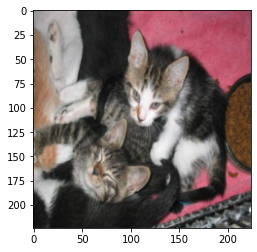

In [13]:
imshow(train[49][0])

In [14]:
#creating data generators
train_data_gen = torch.utils.data.DataLoader(train, shuffle=True, batch_size=64)
valid_data_gen = torch.utils.data.DataLoader(valid, batch_size=64)

In [15]:
dataset_sizes = {'train':len(train_data_gen.dataset), 
                 'valid':len(valid_data_gen.dataset)}

In [16]:
dataloaders = {'train':train_data_gen,
                'valid':valid_data_gen}

In [17]:
#create a network
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
#change output feature of last layer to 2
model_ft.fc = nn.Linear(num_ftrs,2)
'''
if torch.cuda.is_available():
    model_ft = model_ft.cuda()
'''

'\nif torch.cuda.is_available():\n    model_ft = model_ft.cuda()\n'

In [18]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
#Loss and Optimizer
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(),
                        lr=learning_rate,
                        momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft,
                                      step_size=7,
                                      gamma=0.1)

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if torch.cuda.is_available():
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    scheduler.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
'''
model_ft = train_model(model_ft, 
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs =2)
'''


Epoch 0/1
----------
